In [18]:
#directory of the dataset for classification
base_dir = '/binaryclass/rhinorm'


train_dir = '/binaryclass/rhinorm/train'
validation_dir = '/binaryclass/rhinorm/validation'
test_dir = '/binaryclass/rhinorm/test'

In [19]:


import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.optimizers import Nadam




# Set up the data generators with data augmentation for the train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

# Load the MobileNetV2 model without the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



# Add custom layers on top of the base model with batch normalization and regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Add L2 regularization
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers to use the pre-trained weights
for layer in base_model.layers:
    layer.trainable = False


custom_lr = 1e-4
optimizer = Adam(learning_rate=custom_lr)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# # Add early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
early_stopping = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='/binaryclass_output/mobilenet_v2/mobilenet_v2_binaclass_best_model.h5', monitor='val_loss', save_best_only=True)]

#log the training epochs
log_path = "/binaryclass_output/mobilenet_v2/mobilenet_v2_binaclass.log"
csv_callback = tf.keras.callbacks.CSVLogger(log_path, separator=',', append=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, csv_callback])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')


Found 8374 images belonging to 2 classes.
Found 2392 images belonging to 2 classes.
Found 1197 images belonging to 2 classes.
Epoch 1/50
262/262 [==============================] - 51s 189ms/step - loss: 2.1839 - accuracy: 0.9402 - val_loss: 1.7893 - val_accuracy: 0.9958
Epoch 2/50
262/262 [==============================] - 49s 188ms/step - loss: 1.4928 - accuracy: 0.9861 - val_loss: 1.2227 - val_accuracy: 0.9992
Epoch 3/50
262/262 [==============================] - 49s 187ms/step - loss: 1.0466 - accuracy: 0.9897 - val_loss: 0.8517 - val_accuracy: 1.0000
Epoch 4/50
262/262 [==============================] - 49s 188ms/step - loss: 0.7354 - accuracy: 0.9934 - val_loss: 0.6033 - val_accuracy: 1.0000
Epoch 5/50
262/262 [==============================] - 49s 187ms/step - loss: 0.5270 - accuracy: 0.9926 - val_loss: 0.4306 - val_accuracy: 1.0000
Epoch 6/50
262/262 [==============================] - 49s 188ms/step - loss: 0.3834 - accuracy: 0.9932 - val_loss: 0.3112 - val_accuracy: 0.9987
Epoc

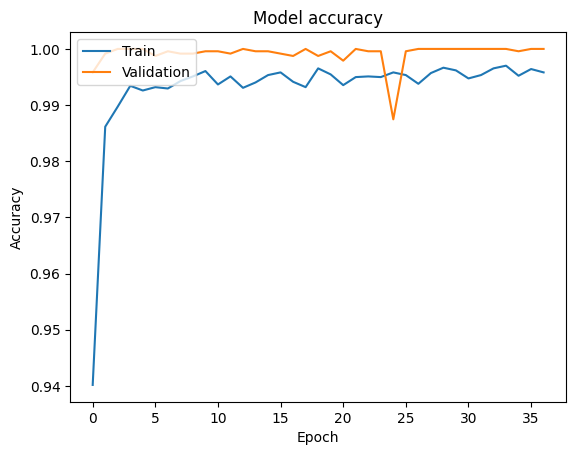

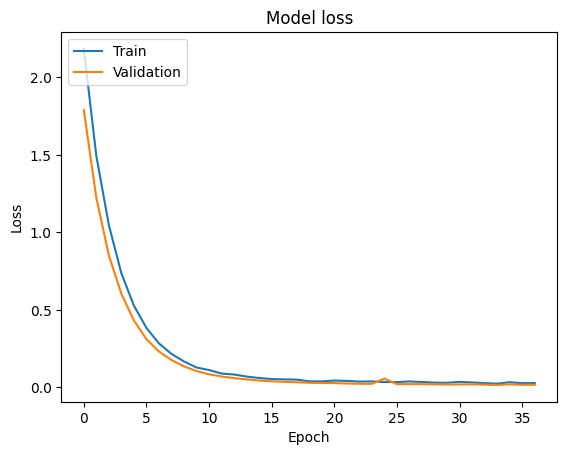

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/mobilenet_v2_binaclass_accuracy_plot.png', dpi=300, bbox_inches='tight')  
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/mobilenet_v2_binaclass_loss_plot.png', dpi=300, bbox_inches='tight')  # Save the loss plot as an image
plt.show()


In [21]:

#to get the class labels assigned by the model during training.
class_dict = train_generator.class_indices
print(class_dict)


{'norm': 0, 'rhi': 1}


In [8]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


test_dir = '/binaryclass/rhinorm/test'

# Load the saved model .h5 file
loaded_model = load_model('/mobilenet_v2/mobilenet_v2_binaclass_best_model.h5')

# Create the test generator with the same preprocessing as used during training
test_datagen = ImageDataGenerator(rescale=1./255)

# Prepare the test data

test_generator = test_datagen.flow_from_directory(
    test_dir,  # Replace with the path to your test directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

# Evaluate the loaded model on the test data
test_loss, test_accuracy = loaded_model.evaluate(test_generator)

# Print the test score (loss and accuracy)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

# Write the test score (loss and accuracy) to a file
with open('/mobilenet_v2_binaclass_test_results.txt', 'w') as file:
    file.write(f'Test loss: {test_loss}\n')
    file.write(f'Test accuracy: {test_accuracy}\n')


Found 1197 images belonging to 2 classes.
38/38 [==============================] - 2s 28ms/step - loss: 0.0193 - accuracy: 1.0000
Test loss: 0.019327299669384956
Test accuracy: 1.0


In [9]:

import numpy as np
from sklearn.metrics import classification_report

# Get true labels and predicted labels from the test set
true_labels = test_generator.classes
predicted_probs = loaded_model.predict(test_generator)
predicted_labels = np.round(predicted_probs).flatten().astype(int)

# Calculate the classification report
report = classification_report(true_labels, predicted_labels, output_dict=True, target_names=['norm', 'rhi'])
report_str = classification_report(true_labels, predicted_labels, target_names=['norm', 'rhi'])

# Print the classification report
print(report_str)

# Save classification report to file
with open('/mobilenet_v2_binaclass_classification_report_.txt', 'w') as f:
     f.write(report_str)

38/38 [==============================] - 1s 26ms/step
              precision    recall  f1-score   support

        norm       1.00      1.00      1.00       600
         rhi       1.00      1.00      1.00       597

    accuracy                           1.00      1197
   macro avg       1.00      1.00      1.00      1197
weighted avg       1.00      1.00      1.00      1197



In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predict class labels on the test set
y_pred_probs = loaded_model.predict(test_generator)
y_pred = np.round(y_pred_probs).flatten()  # Round probabilities to get class labels

# Get the true class labels from the test set
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix as an array
print(cm)

38/38 [==============================] - 1s 27ms/step
[[600   0]
 [  0 597]]


38/38 [==============================] - 1s 26ms/step


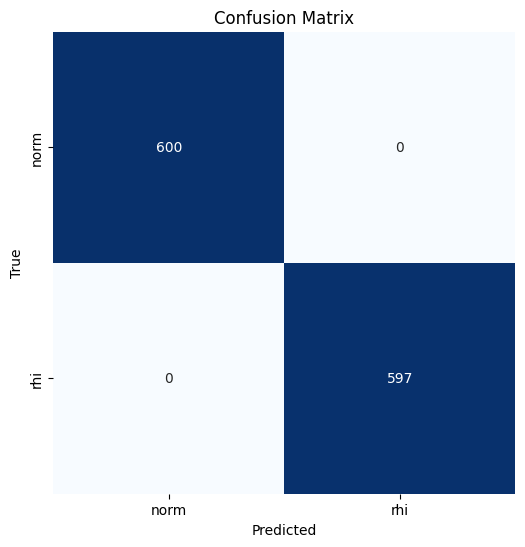

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict class labels on the test set
y_pred_probs = loaded_model.predict(test_generator)
y_pred = np.round(y_pred_probs).flatten() 

# Get the true class labels from the test set
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=['norm', 'rhi'], yticklabels=['norm', 'rhi'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('/mobilenet_v2_binaclass_cmatrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
###################################
##################################
#################################
# BELOW IS FOR TESTING THE RESULTS ON REAL RHINOPHYMA IMAGES
#################################
##################################
###################################

In [5]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#test_dir = 'gdrive/My Drive/test_2'
test_dir = '/real_rhinorm/test'

# Load the saved model .h5 file
loaded_model = load_model('/mobilenet_v2_binaclass_best_model.h5')

# Create the test generator with the same preprocessing as used during training
test_datagen = ImageDataGenerator(rescale=1./255)

# Prepare the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Replace with the path to your test directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

# Evaluate the loaded model on the test data
test_loss, test_accuracy = loaded_model.evaluate(test_generator)

# Print the test score (loss and accuracy)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

Write the test score (loss and accuracy) to a file
with open('/mobilenet_v2_binaclass_test_results_REAL.txt', 'w') as file:
    file.write(f'Test loss: {test_loss}\n')
    file.write(f'Test accuracy: {test_accuracy}\n')


Found 440 images belonging to 2 classes.
14/14 [==============================] - 1s 57ms/step - loss: 0.0839 - accuracy: 0.9773
Test loss: 0.08392634242773056
Test accuracy: 0.9772727489471436


In [44]:
#CLASSIFICATION REPORT

import numpy as np
from sklearn.metrics import classification_report

# Get true labels and predicted labels from the test set
true_labels = test_generator.classes
predicted_probs = loaded_model.predict(test_generator)
predicted_labels = np.round(predicted_probs).flatten().astype(int)

# Calculate the classification report
report = classification_report(true_labels, predicted_labels, output_dict=True, target_names=['norm', 'rhi'])
report_str = classification_report(true_labels, predicted_labels, target_names=['norm', 'rhi'])

# Print the classification report
print(report_str)

# Save classification report to file
with open('/mobilenet_v2_binaclass_classification_report_REAL.txt', 'w') as f:
    f.write(report_str)

14/14 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

        norm       0.96      1.00      0.98       220
         rhi       1.00      0.95      0.98       220

    accuracy                           0.98       440
   macro avg       0.98      0.98      0.98       440
weighted avg       0.98      0.98      0.98       440



In [45]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predict class labels on the test set
y_pred_probs = loaded_model.predict(test_generator)
y_pred = np.round(y_pred_probs).flatten()  # Round probabilities to get class labels

# Get the true class labels from the test set
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix as an array
print(cm)

14/14 [==============================] - 1s 37ms/step
[[220   0]
 [ 10 210]]


14/14 [==============================] - 1s 36ms/step


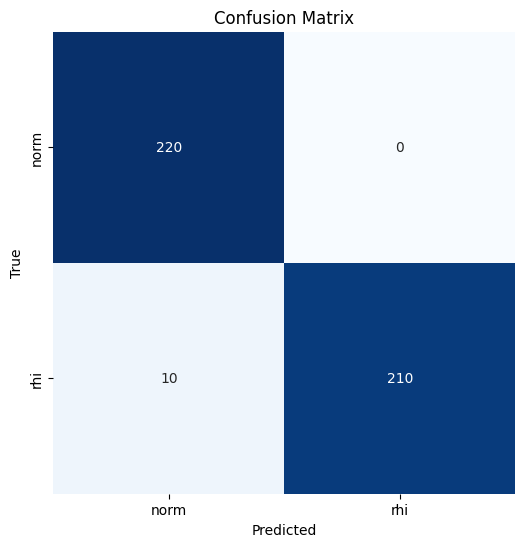

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict class labels on the test set
y_pred_probs = loaded_model.predict(test_generator)
y_pred = np.round(y_pred_probs).flatten()  # Round probabilities to get class labels

# Get the true class labels from the test set
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=['norm', 'rhi'], yticklabels=['norm', 'rhi'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('/mobilenet_v2_binaclass_cmatrix_REAL.png', dpi=300, bbox_inches='tight')
plt.show()